In [186]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# early stopping
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 데이터셋 경로 지정
train_horse_dir = './data/train_added/horses'
train_human_dir = './data/train_added/humans'


In [187]:
train_horse_names = os.listdir(train_horse_dir)
train_human_names = os.listdir(train_human_dir)

In [188]:
horse_files = [train_horse_dir + '/' + f for f in train_horse_names]
human_files = [train_human_dir + '/' + f for f in train_human_names]

In [189]:
print('horse:', len(train_horse_names))
print('human:', len(train_human_names))


horse: 1454
human: 1436


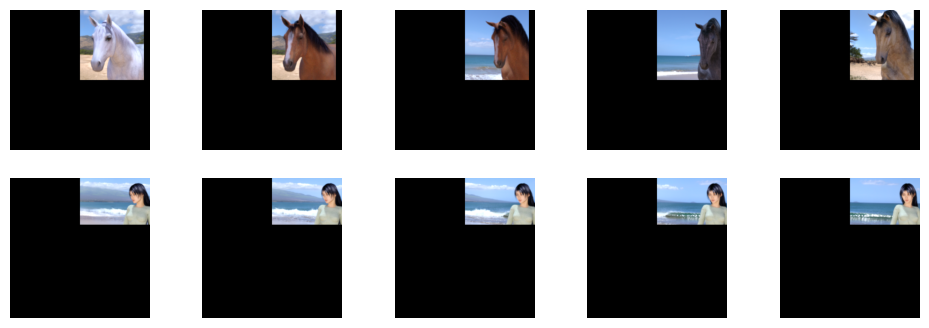

In [190]:
fig, axes = plt.subplots(2,5, figsize=(12,4))
ax = np.reshape(axes, -1)

for i, path in enumerate(horse_files[:5] + human_files[:5]):
    img = plt.imread(path)
    ax[i].axis('off')
    ax[i].imshow(img)

plt.show()

In [191]:
# 모델 설계
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_75 (Conv2D)              │ (None, 298, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 147, 147, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,704,097 (6.50 MB)

 Trainable params: 1,704,097 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

In [192]:
model.compile(loss='binary_crossentropy',
            optimizer=Adam(learning_rate=0.0001),
            metrics=['accuracy'])

In [193]:
# 이미지 값을 0~1 사이로 제한
train_datagen = ImageDataGenerator(rescale=1/255)

# train set
train_generator = train_datagen.flow_from_directory(
  './data/train_added/',
  target_size=(300, 300),  # 해상도 조절
  batch_size=128,  # 배치 크기
  class_mode='binary'  # 분류 방법
)

# valid set
valid_generator = train_datagen.flow_from_directory(
  './data/validation-horse-or-human/',
  target_size=(300, 300),
  batch_size=128,
  class_mode='binary'
)

# 얼리스토핑 초기화
es = EarlyStopping(
    monitor='loss',
    patience=3
)

# 모델 체크포인트 초기화
checkpoint = ModelCheckpoint(
    filepath = './checkpoint.keras',
    verbose = 2,
    save_best_only = True,
    mode = 'auto'
)



# 모델 학습
history = model.fit(
  train_generator,
  steps_per_epoch=8,
  epochs=15,
  verbose=1,
  callbacks=[checkpoint, es]
)

Found 2890 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6042 - loss: 0.6824
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7136 - loss: 0.6247
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 492ms/step - accuracy: 0.7333 - loss: 0.5790
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 882ms/step - accuracy: 0.8038 - loss: 0.5067
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 692ms/step - accuracy: 0.8349 - loss: 0.3962
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 530ms/step - accuracy: 0.8949 - loss: 0.2890
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 755ms/step - accuracy: 0.8789 - loss: 0.2652
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 675ms/step - accuracy: 0.9504 - loss: 0.1826
Epoch 9/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 472ms/step - accuracy: 0.9549 - loss: 0.1689
Epoch 10/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 679ms/step - accuracy: 0.9345 - loss: 0.1979
Epoch 11/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 679ms/step - accuracy: 0.9531 - loss: 0.

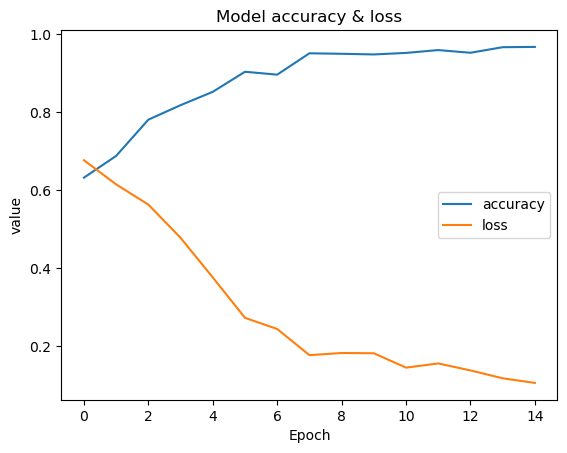

In [194]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy & loss')
plt.xlabel('Epoch')
plt.ylabel('value')
plt.legend(['accuracy', 'loss'], loc='center right')
plt.show()

In [195]:
# 모델 검증
results = model.evaluate(valid_generator)
print("test loss, test acc:", results)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step - accuracy: 0.7760 - loss: 1.2528
test loss, test acc: [1.255906105041504, 0.77734375]


In [196]:
# 이미지 전처리
dlist = './data/test-horse-or-human/'
predict_list = os.listdir(dlist)
print(predict_list)

img = [cv2.imread(dlist + i) for i in predict_list]
img = [cv2.resize(i, (300,300)) for i in img]
img = np.array(img)
img = img.astype('float32') / 255.0

# 분류
cutoff = .5
predictions = model.predict(img)
print(predictions >= cutoff)

['horse1.jpg', 'horse2.webp', 'horse3.jpg', 'human1.jpg', 'human2.jpg']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
[[False]
 [False]
 [ True]
 [ True]
 [ True]]


In [197]:
# 모델 저장하기
model.save('./model.keras')